In [ ]:
import numpy as np
import pandas as pd
import os
import time

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from random import randint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# IMPORTANT: change to your own root folder path!
root_folder = "/content/drive/MyDrive/SAAS_DF_Dataset/Alzheimer MRI Disease Classification Dataset/Data/"
os.chdir(root_folder)
# validate that we're in the right directory
!pwd
!ls

In [ ]:
df=pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet")
val_data=pd.read_parquet('test-00000-of-00001-44110b9df98c5585.parquet')
# Reading in the parquet files (my data)

In [ ]:
print(df.head(5))
print("*"*100)
print(val_data.head(5))
print("*"*100)
print(df.shape,val_data.shape)

In [ ]:
df['label'].value_counts()

In [ ]:
val_data['label'].value_counts()

In [ ]:
def convert_to_format(bytes_df):
    img_arr=np.frombuffer(bytes_df,dtype=np.uint8) # frombuffer is used to convert the bytes to np.array
    img=cv2.imdecode(img_arr,cv2.IMREAD_COLOR)    # here cv2 imdecode is used for readblity formate and IMREAD_COLOR is used for rgb color format image
    return img

images=[]

def get_img(df):
    images=[]
    for i in range(len(df)):
        inputt=df.iloc[i]['image']['bytes']
        cv_data=convert_to_format(inputt)
        images.append(cv_data)
    return images
#applies convert_to_format to entire file to train and test dataset to get all images in np.array form
images=get_img(df)
images_val=get_img(val_data)

In [ ]:
plt.figure(figsize=(12,9))
plt.subplot(241)
plt.imshow(cv2.cvtColor(images_val[0],cv2.COLOR_BGR2RGB))
plt.title('mri-0-' + str(df.iloc[0]['label']))

In [ ]:
def get_images_per_label(df):
    selected_images = {}  # Dictionary to store one image per label

    for i in range(len(df)):
        label = df.iloc[i]['label']  # Get the label of the current image
        if label not in selected_images:  # Check if this label is already stored
            input = df.iloc[i]['image']['bytes']
            cv_data = convert_to_format(input)
            selected_images[label] = cv_data  # Store the first found image for this label
        if len(selected_images) == 4:  # Stop when we have all 4 labels
            break

    return selected_images  # Return dictionary with 4 images (one per label)

0 → Mild Demented

1 → Moderate Demented

2 → Non-Demented

3 → Very Mild Demented

In [ ]:
mri_images = get_images_per_label(df)

# Display the images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, (label, img) in enumerate(mri_images.items()):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Label {label}")
    axes[i].axis("off")
plt.show()

In [ ]:
#get images all from class 0

import matplotlib.pyplot as plt
import cv2

def get_images_class_0(df):
    class_0_images = []
    for i in range(len(df)):
        if df.iloc[i]['label'] == 3:
            inputt = df.iloc[i]['image']['bytes']
            cv_data = convert_to_format(inputt)
            class_0_images.append(cv_data)
    return class_0_images

class_0_images = get_images_class_0(df)

# Display the first 5 images from class 0 (adjust the range as needed)
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(min(4, len(class_0_images))):
  axes[i].imshow(cv2.cvtColor(class_0_images[i], cv2.COLOR_BGR2RGB))
  axes[i].set_title(f"Class 3 - Image {i}")
  axes[i].axis("off")
plt.show()

In [ ]:
preprocess = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[.1]*3, std=[0.4]*3)  # more general for grayscale converted to 3 channel
])
def apply_preprocess(images):
    images_transform = []
    for i in tqdm(range(len(images))):
        img_pil = Image.fromarray(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), mode='RGB')
        img_transformed = preprocess(img_pil)
        images_transform.append(img_transformed)
    return images_transform
images_transform_train = apply_preprocess(images)
images_transform_val = apply_preprocess(images_val)



In [ ]:
#how to plt.imshow multiple images at once

import matplotlib.pyplot as plt
import numpy as np
# Assuming 'images_transform_train' and 'images_transform_val' are your preprocessed image tensors.

#Displaying the first 4 images from the training set
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i in range(4):
    # Convert the tensor to a NumPy array and undo the normalization
    image = images_transform_train[i].numpy().T
    image = np.clip(image, 0, 1) # Ensure pixel values are within the valid range

    axes[i].imshow(image)
    axes[i].axis("off")

plt.show()

#Displaying images from both training and validation sets
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i in range(4):

    image_val = images_transform_val[i].numpy().T
    image_val = np.clip(image_val, 0, 1)
    axes[i].imshow(image_val)
    axes[i].axis("off")

plt.show()


In [ ]:
#Using Logistic Regression first

X_train = np.array([img.flatten() for img in images_transform_train])
X_val = np.array([img.flatten() for img in images_transform_val])

# Extract labels
y_train = df['label'].values
y_val = val_data['label'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

scaler = StandardScaler()
X_train_tensor = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_val_tensor = torch.tensor(scaler.transform(X_val), dtype=torch.float32)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.sigmoid(self.fc(x))

device = torch.device("cuda")

input_dim = 3 * 128 * 128
output_dim = 4
model = LogisticRegressionModel(input_dim, output_dim).to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
epochs = 20  # Number of epochs

for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # Move data to the GPU
    inputs, labels = X_train_tensor.to(device), y_train_tensor.to(device)

    # Forward pass
    outputs = model(inputs)

    # Calculate the loss
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Move validation data to GPU
    inputs, labels = X_val_tensor.to(device), y_val_tensor.to(device)

    # Get predictions
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # Convert predictions and true labels back to CPU
    predicted = predicted.cpu().numpy()
    labels = labels.cpu().numpy()

# Calculate accuracy and print classification report
accuracy = accuracy_score(labels, predicted)
print(f"Accuracy: {accuracy}")
print(classification_report(labels, predicted))


NameError: name 'images_transform_train' is not defined

In [ ]:
#convert data frame into PyTorch dataset

from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

# Example usage (assuming you have 'images' and 'labels' defined):
train_labels = df['label'].values
val_labels = val_data['label'].values
train_dataset = CustomImageDataset(images_transform_train, train_labels)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
)
val_dataset = CustomImageDataset(images_transform_val, val_labels)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
)


In [ ]:
#hard coded CNN
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride = 1),  # Input: (3, 128, 128)
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # → (64, 62, 62)
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # → (32, 29, 29)
            nn.ReLU(),

             nn.Conv2d(32, 16, kernel_size=5),
             nn.BatchNorm2d(16),
             nn.MaxPool2d(2),  # → (16, 12, 12)
             nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*12*12, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 4)  # 4 classes

    def forward(self, x):
        y = self.model(x)
        y = self.flatten(y)
        y = F.relu(self.fc1(y))
        y = self.dropout(y)
        y = self.fc2(y)
        return y

In [ ]:
model = CNNModel()

In [ ]:
#applying class weights for class imbalance
weights = 1/train_labels
weights = np.append(weights, weights[0])
weights = np.append(weights, weights[1])
weights = np.delete(weights, [0,1])
weights = torch.Tensor(weights)
weights

NameError: name 'train_labels' is not defined

In [ ]:
#training using hard-coded CNN
from psutil import virtual_memory
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda")
print(f"Using device: {device}")

model = CNNModel()
model = model.to(device)
train_labels = np.array(df['label'].value_counts())
train_labels
weights = torch.Tensor([0.0026, 0.01, 0.0008, 0.001])
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

num_epochs = 25  # Adjust as needed

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:  # Print every 20 mini-batches
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/20:.4f}")
            running_loss = 0.0


    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in val_loader:
            val_images, val_labels = data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = model(val_images)  # Use val_images here
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    print(f"Accuracy of the network on the validation images: {100 * correct / total}%")
    print(classification_report(all_labels, all_preds))

print("Finished Training")

# Save the model
torch.save(model.state_dict(), "cnn_finetuned.pth")

Using device: cuda


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1, Batch 20, Loss: 1.3733
Epoch 1, Batch 40, Loss: 1.2676
Epoch 1, Batch 60, Loss: 1.2628
Epoch 1, Batch 80, Loss: 1.1305
Epoch 1, Batch 100, Loss: 1.2395
Epoch 1, Batch 120, Loss: 1.2660
Epoch 1, Batch 140, Loss: 1.2246
Epoch 1, Batch 160, Loss: 1.2012
Epoch 1, Batch 180, Loss: 1.1930
Epoch 1, Batch 200, Loss: 1.0700
Epoch 1, Batch 220, Loss: 0.9951
Epoch 1, Batch 240, Loss: 1.0478
Epoch 1, Batch 260, Loss: 1.1714
Epoch 1, Batch 280, Loss: 1.1322
Epoch 1, Batch 300, Loss: 1.2067
Epoch 1, Batch 320, Loss: 1.1052


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|▍         | 1/25 [00:06<02:34,  6.45s/it]

Accuracy of the network on the validation images: 54.53125%
              precision    recall  f1-score   support

           0       0.29      0.49      0.37       172
           1       0.00      0.00      0.00        15
           2       0.64      0.76      0.70       634
           3       0.55      0.28      0.37       459

    accuracy                           0.55      1280
   macro avg       0.37      0.38      0.36      1280
weighted avg       0.55      0.55      0.53      1280

Epoch 2, Batch 20, Loss: 1.1107
Epoch 2, Batch 40, Loss: 1.0389
Epoch 2, Batch 60, Loss: 1.1534
Epoch 2, Batch 80, Loss: 1.1129
Epoch 2, Batch 100, Loss: 1.0736
Epoch 2, Batch 120, Loss: 1.1156
Epoch 2, Batch 140, Loss: 1.1330
Epoch 2, Batch 160, Loss: 1.1238
Epoch 2, Batch 180, Loss: 1.0861
Epoch 2, Batch 200, Loss: 1.0864
Epoch 2, Batch 220, Loss: 1.1924
Epoch 2, Batch 240, Loss: 1.0437
Epoch 2, Batch 260, Loss: 1.0990
Epoch 2, Batch 280, Loss: 1.0465
Epoch 2, Batch 300, Loss: 1.0056
Epoch 2, Batch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|▊         | 2/25 [00:13<02:35,  6.75s/it]

Accuracy of the network on the validation images: 17.890625%
              precision    recall  f1-score   support

           0       0.18      0.99      0.30       172
           1       0.00      0.00      0.00        15
           2       1.00      0.01      0.02       634
           3       0.17      0.12      0.14       459

    accuracy                           0.18      1280
   macro avg       0.34      0.28      0.11      1280
weighted avg       0.58      0.18      0.10      1280

Epoch 3, Batch 20, Loss: 1.0621
Epoch 3, Batch 40, Loss: 1.0489
Epoch 3, Batch 60, Loss: 0.9666
Epoch 3, Batch 80, Loss: 1.0498
Epoch 3, Batch 100, Loss: 1.0317
Epoch 3, Batch 120, Loss: 0.9426
Epoch 3, Batch 140, Loss: 0.9902
Epoch 3, Batch 160, Loss: 1.0294
Epoch 3, Batch 180, Loss: 1.0561
Epoch 3, Batch 200, Loss: 1.0477
Epoch 3, Batch 220, Loss: 1.0927
Epoch 3, Batch 240, Loss: 0.9679
Epoch 3, Batch 260, Loss: 1.0409
Epoch 3, Batch 280, Loss: 1.0246
Epoch 3, Batch 300, Loss: 0.9603
Epoch 3, Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 3/25 [00:19<02:26,  6.67s/it]

Accuracy of the network on the validation images: 52.265625%
              precision    recall  f1-score   support

           0       0.30      0.81      0.44       172
           1       0.00      0.00      0.00        15
           2       0.67      0.73      0.70       634
           3       0.55      0.14      0.23       459

    accuracy                           0.52      1280
   macro avg       0.38      0.42      0.34      1280
weighted avg       0.57      0.52      0.49      1280

Epoch 4, Batch 20, Loss: 0.9284
Epoch 4, Batch 40, Loss: 0.9364
Epoch 4, Batch 60, Loss: 0.9824
Epoch 4, Batch 80, Loss: 0.9451
Epoch 4, Batch 100, Loss: 0.9522
Epoch 4, Batch 120, Loss: 0.9717
Epoch 4, Batch 140, Loss: 0.9909
Epoch 4, Batch 160, Loss: 1.0518
Epoch 4, Batch 180, Loss: 1.0519
Epoch 4, Batch 200, Loss: 0.9596
Epoch 4, Batch 220, Loss: 1.0003
Epoch 4, Batch 240, Loss: 0.8684
Epoch 4, Batch 260, Loss: 1.1365
Epoch 4, Batch 280, Loss: 0.9581
Epoch 4, Batch 300, Loss: 1.0320
Epoch 4, Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█▌        | 4/25 [00:26<02:20,  6.71s/it]

Accuracy of the network on the validation images: 54.453125%
              precision    recall  f1-score   support

           0       0.32      0.86      0.46       172
           1       0.00      0.00      0.00        15
           2       0.81      0.55      0.66       634
           3       0.52      0.44      0.48       459

    accuracy                           0.54      1280
   macro avg       0.41      0.46      0.40      1280
weighted avg       0.63      0.54      0.56      1280

Epoch 5, Batch 20, Loss: 0.9687
Epoch 5, Batch 40, Loss: 0.9457
Epoch 5, Batch 60, Loss: 0.8816
Epoch 5, Batch 80, Loss: 0.8559
Epoch 5, Batch 100, Loss: 0.9863
Epoch 5, Batch 120, Loss: 0.9706
Epoch 5, Batch 140, Loss: 0.9537
Epoch 5, Batch 160, Loss: 0.9624
Epoch 5, Batch 180, Loss: 0.9640
Epoch 5, Batch 200, Loss: 0.8585
Epoch 5, Batch 220, Loss: 0.9193
Epoch 5, Batch 240, Loss: 0.9118
Epoch 5, Batch 260, Loss: 0.9688
Epoch 5, Batch 280, Loss: 0.8975
Epoch 5, Batch 300, Loss: 0.9513
Epoch 5, Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 5/25 [00:33<02:11,  6.57s/it]

Accuracy of the network on the validation images: 54.0625%
              precision    recall  f1-score   support

           0       0.33      0.83      0.47       172
           1       0.00      0.00      0.00        15
           2       0.71      0.68      0.70       634
           3       0.50      0.26      0.34       459

    accuracy                           0.54      1280
   macro avg       0.38      0.44      0.38      1280
weighted avg       0.57      0.54      0.53      1280

Epoch 6, Batch 20, Loss: 0.8823
Epoch 6, Batch 40, Loss: 0.9340
Epoch 6, Batch 60, Loss: 0.9114
Epoch 6, Batch 80, Loss: 0.8438
Epoch 6, Batch 100, Loss: 0.8764
Epoch 6, Batch 120, Loss: 0.8415
Epoch 6, Batch 140, Loss: 0.8801
Epoch 6, Batch 160, Loss: 0.8461
Epoch 6, Batch 180, Loss: 0.9074
Epoch 6, Batch 200, Loss: 0.8553
Epoch 6, Batch 220, Loss: 0.9053
Epoch 6, Batch 240, Loss: 0.8587
Epoch 6, Batch 260, Loss: 0.8766
Epoch 6, Batch 280, Loss: 0.7839
Epoch 6, Batch 300, Loss: 0.8632
Epoch 6, Batch 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██▍       | 6/25 [00:39<02:06,  6.65s/it]

Accuracy of the network on the validation images: 46.484375%
              precision    recall  f1-score   support

           0       0.26      0.98      0.41       172
           1       0.00      0.00      0.00        15
           2       0.91      0.45      0.60       634
           3       0.46      0.31      0.37       459

    accuracy                           0.46      1280
   macro avg       0.41      0.44      0.34      1280
weighted avg       0.65      0.46      0.48      1280

Epoch 7, Batch 20, Loss: 0.7777
Epoch 7, Batch 40, Loss: 0.8071
Epoch 7, Batch 60, Loss: 0.8353
Epoch 7, Batch 80, Loss: 0.8518
Epoch 7, Batch 100, Loss: 0.8080
Epoch 7, Batch 120, Loss: 0.8015
Epoch 7, Batch 140, Loss: 0.7748
Epoch 7, Batch 160, Loss: 0.8005
Epoch 7, Batch 180, Loss: 0.8589
Epoch 7, Batch 200, Loss: 0.7548
Epoch 7, Batch 220, Loss: 0.8720
Epoch 7, Batch 240, Loss: 0.8541
Epoch 7, Batch 260, Loss: 0.8030
Epoch 7, Batch 280, Loss: 0.7973
Epoch 7, Batch 300, Loss: 0.8703
Epoch 7, Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|██▊       | 7/25 [00:46<01:57,  6.52s/it]

Accuracy of the network on the validation images: 47.109375%
              precision    recall  f1-score   support

           0       0.26      0.98      0.42       172
           1       0.00      0.00      0.00        15
           2       0.90      0.46      0.61       634
           3       0.45      0.31      0.36       459

    accuracy                           0.47      1280
   macro avg       0.40      0.44      0.35      1280
weighted avg       0.64      0.47      0.49      1280

Epoch 8, Batch 20, Loss: 0.7357
Epoch 8, Batch 40, Loss: 0.7049
Epoch 8, Batch 60, Loss: 0.7681
Epoch 8, Batch 80, Loss: 0.7129
Epoch 8, Batch 100, Loss: 0.7299
Epoch 8, Batch 120, Loss: 0.7338
Epoch 8, Batch 140, Loss: 0.8480
Epoch 8, Batch 160, Loss: 0.7444
Epoch 8, Batch 180, Loss: 0.7007
Epoch 8, Batch 200, Loss: 0.7605
Epoch 8, Batch 220, Loss: 0.8657
Epoch 8, Batch 240, Loss: 0.6643
Epoch 8, Batch 260, Loss: 0.8359
Epoch 8, Batch 280, Loss: 0.7285
Epoch 8, Batch 300, Loss: 0.7923
Epoch 8, Batc

 32%|███▏      | 8/25 [00:52<01:52,  6.61s/it]

Accuracy of the network on the validation images: 63.59375%
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       172
           1       1.00      0.33      0.50        15
           2       0.66      0.85      0.75       634
           3       0.52      0.31      0.39       459

    accuracy                           0.64      1280
   macro avg       0.71      0.56      0.59      1280
weighted avg       0.62      0.64      0.61      1280

Epoch 9, Batch 20, Loss: 0.7247
Epoch 9, Batch 40, Loss: 0.6953
Epoch 9, Batch 60, Loss: 0.7616
Epoch 9, Batch 80, Loss: 0.6705
Epoch 9, Batch 100, Loss: 0.6767
Epoch 9, Batch 120, Loss: 0.6901
Epoch 9, Batch 140, Loss: 0.7157
Epoch 9, Batch 160, Loss: 0.7088
Epoch 9, Batch 180, Loss: 0.6537
Epoch 9, Batch 200, Loss: 0.7233
Epoch 9, Batch 220, Loss: 0.7762
Epoch 9, Batch 240, Loss: 0.6016
Epoch 9, Batch 260, Loss: 0.7389
Epoch 9, Batch 280, Loss: 0.7113
Epoch 9, Batch 300, Loss: 0.7429
Epoch 9, Batch

 36%|███▌      | 9/25 [00:59<01:44,  6.51s/it]

Accuracy of the network on the validation images: 32.8125%
              precision    recall  f1-score   support

           0       0.20      0.99      0.33       172
           1       0.93      0.87      0.90        15
           2       0.92      0.28      0.43       634
           3       0.27      0.12      0.17       459

    accuracy                           0.33      1280
   macro avg       0.58      0.57      0.46      1280
weighted avg       0.59      0.33      0.33      1280

Epoch 10, Batch 20, Loss: 0.7063
Epoch 10, Batch 40, Loss: 0.7434
Epoch 10, Batch 60, Loss: 0.7103
Epoch 10, Batch 80, Loss: 0.5956
Epoch 10, Batch 100, Loss: 0.6524
Epoch 10, Batch 120, Loss: 0.6853
Epoch 10, Batch 140, Loss: 0.6431
Epoch 10, Batch 160, Loss: 0.6351
Epoch 10, Batch 180, Loss: 0.7068
Epoch 10, Batch 200, Loss: 0.7681
Epoch 10, Batch 220, Loss: 0.7244
Epoch 10, Batch 240, Loss: 0.6478
Epoch 10, Batch 260, Loss: 0.5861
Epoch 10, Batch 280, Loss: 0.5997
Epoch 10, Batch 300, Loss: 0.5867


 40%|████      | 10/25 [01:06<01:39,  6.63s/it]

Accuracy of the network on the validation images: 72.890625%
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       172
           1       1.00      0.67      0.80        15
           2       0.75      0.82      0.78       634
           3       0.66      0.57      0.61       459

    accuracy                           0.73      1280
   macro avg       0.80      0.72      0.75      1280
weighted avg       0.73      0.73      0.72      1280

Epoch 11, Batch 20, Loss: 0.6760
Epoch 11, Batch 40, Loss: 0.6659
Epoch 11, Batch 60, Loss: 0.6112
Epoch 11, Batch 80, Loss: 0.5477
Epoch 11, Batch 100, Loss: 0.6149
Epoch 11, Batch 120, Loss: 0.5976
Epoch 11, Batch 140, Loss: 0.6441
Epoch 11, Batch 160, Loss: 0.5497
Epoch 11, Batch 180, Loss: 0.5794
Epoch 11, Batch 200, Loss: 0.5432
Epoch 11, Batch 220, Loss: 0.6474
Epoch 11, Batch 240, Loss: 0.7003
Epoch 11, Batch 260, Loss: 0.6121
Epoch 11, Batch 280, Loss: 0.6050
Epoch 11, Batch 300, Loss: 0.541

 44%|████▍     | 11/25 [01:12<01:31,  6.53s/it]

Accuracy of the network on the validation images: 75.15625%
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       172
           1       1.00      0.33      0.50        15
           2       0.83      0.74      0.78       634
           3       0.63      0.78      0.69       459

    accuracy                           0.75      1280
   macro avg       0.84      0.66      0.70      1280
weighted avg       0.77      0.75      0.75      1280

Epoch 12, Batch 20, Loss: 0.6024
Epoch 12, Batch 40, Loss: 0.5396
Epoch 12, Batch 60, Loss: 0.6462
Epoch 12, Batch 80, Loss: 0.5963
Epoch 12, Batch 100, Loss: 0.5468
Epoch 12, Batch 120, Loss: 0.5922
Epoch 12, Batch 140, Loss: 0.4994
Epoch 12, Batch 160, Loss: 0.4986
Epoch 12, Batch 180, Loss: 0.5226
Epoch 12, Batch 200, Loss: 0.5246
Epoch 12, Batch 220, Loss: 0.5923
Epoch 12, Batch 240, Loss: 0.5158
Epoch 12, Batch 260, Loss: 0.5361
Epoch 12, Batch 280, Loss: 0.5746
Epoch 12, Batch 300, Loss: 0.5546

 48%|████▊     | 12/25 [01:19<01:26,  6.62s/it]

Accuracy of the network on the validation images: 73.28125%
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       172
           1       1.00      0.27      0.42        15
           2       0.73      0.90      0.81       634
           3       0.66      0.54      0.60       459

    accuracy                           0.73      1280
   macro avg       0.84      0.59      0.65      1280
weighted avg       0.74      0.73      0.72      1280

Epoch 13, Batch 20, Loss: 0.4971
Epoch 13, Batch 40, Loss: 0.5305
Epoch 13, Batch 60, Loss: 0.5266
Epoch 13, Batch 80, Loss: 0.5269
Epoch 13, Batch 100, Loss: 0.5519
Epoch 13, Batch 120, Loss: 0.5296
Epoch 13, Batch 140, Loss: 0.5296
Epoch 13, Batch 160, Loss: 0.4941
Epoch 13, Batch 180, Loss: 0.4303
Epoch 13, Batch 200, Loss: 0.5113
Epoch 13, Batch 220, Loss: 0.4927
Epoch 13, Batch 240, Loss: 0.5193
Epoch 13, Batch 260, Loss: 0.4966
Epoch 13, Batch 280, Loss: 0.4664
Epoch 13, Batch 300, Loss: 0.4898

 52%|█████▏    | 13/25 [01:25<01:18,  6.53s/it]

Accuracy of the network on the validation images: 79.375%
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       172
           1       1.00      0.93      0.97        15
           2       0.87      0.79      0.83       634
           3       0.72      0.72      0.72       459

    accuracy                           0.79      1280
   macro avg       0.83      0.86      0.84      1280
weighted avg       0.80      0.79      0.79      1280

Epoch 14, Batch 20, Loss: 0.4538
Epoch 14, Batch 40, Loss: 0.4690
Epoch 14, Batch 60, Loss: 0.4729
Epoch 14, Batch 80, Loss: 0.5000
Epoch 14, Batch 100, Loss: 0.4882
Epoch 14, Batch 120, Loss: 0.4553
Epoch 14, Batch 140, Loss: 0.4741
Epoch 14, Batch 160, Loss: 0.4593
Epoch 14, Batch 180, Loss: 0.4921
Epoch 14, Batch 200, Loss: 0.4792
Epoch 14, Batch 220, Loss: 0.5462
Epoch 14, Batch 240, Loss: 0.4763
Epoch 14, Batch 260, Loss: 0.4555
Epoch 14, Batch 280, Loss: 0.5637
Epoch 14, Batch 300, Loss: 0.4452
E

 56%|█████▌    | 14/25 [01:32<01:12,  6.61s/it]

Accuracy of the network on the validation images: 77.265625%
              precision    recall  f1-score   support

           0       0.68      0.98      0.80       172
           1       1.00      0.80      0.89        15
           2       0.93      0.71      0.80       634
           3       0.67      0.79      0.72       459

    accuracy                           0.77      1280
   macro avg       0.82      0.82      0.80      1280
weighted avg       0.80      0.77      0.78      1280

Epoch 15, Batch 20, Loss: 0.4559
Epoch 15, Batch 40, Loss: 0.3849
Epoch 15, Batch 60, Loss: 0.4378
Epoch 15, Batch 80, Loss: 0.3809
Epoch 15, Batch 100, Loss: 0.4440
Epoch 15, Batch 120, Loss: 0.4771
Epoch 15, Batch 140, Loss: 0.4635
Epoch 15, Batch 160, Loss: 0.4619
Epoch 15, Batch 180, Loss: 0.4536
Epoch 15, Batch 200, Loss: 0.5007
Epoch 15, Batch 220, Loss: 0.5365
Epoch 15, Batch 240, Loss: 0.5602
Epoch 15, Batch 260, Loss: 0.4634
Epoch 15, Batch 280, Loss: 0.4696
Epoch 15, Batch 300, Loss: 0.480

 60%|██████    | 15/25 [01:38<01:05,  6.54s/it]

Accuracy of the network on the validation images: 83.359375%
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       172
           1       1.00      0.80      0.89        15
           2       0.90      0.82      0.86       634
           3       0.75      0.81      0.78       459

    accuracy                           0.83      1280
   macro avg       0.87      0.84      0.85      1280
weighted avg       0.84      0.83      0.83      1280

Epoch 16, Batch 20, Loss: 0.4941
Epoch 16, Batch 40, Loss: 0.3991
Epoch 16, Batch 60, Loss: 0.4308
Epoch 16, Batch 80, Loss: 0.4200
Epoch 16, Batch 100, Loss: 0.4592
Epoch 16, Batch 120, Loss: 0.3725
Epoch 16, Batch 140, Loss: 0.3535
Epoch 16, Batch 160, Loss: 0.3869
Epoch 16, Batch 180, Loss: 0.4482
Epoch 16, Batch 200, Loss: 0.3569
Epoch 16, Batch 220, Loss: 0.3646
Epoch 16, Batch 240, Loss: 0.4391
Epoch 16, Batch 260, Loss: 0.3634
Epoch 16, Batch 280, Loss: 0.3063
Epoch 16, Batch 300, Loss: 0.406

 64%|██████▍   | 16/25 [01:45<00:59,  6.64s/it]

Accuracy of the network on the validation images: 86.5625%
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       172
           1       1.00      0.67      0.80        15
           2       0.88      0.91      0.90       634
           3       0.85      0.78      0.81       459

    accuracy                           0.87      1280
   macro avg       0.89      0.83      0.85      1280
weighted avg       0.87      0.87      0.86      1280

Epoch 17, Batch 20, Loss: 0.3936
Epoch 17, Batch 40, Loss: 0.3930
Epoch 17, Batch 60, Loss: 0.2913
Epoch 17, Batch 80, Loss: 0.3523
Epoch 17, Batch 100, Loss: 0.3232
Epoch 17, Batch 120, Loss: 0.2594
Epoch 17, Batch 140, Loss: 0.3261
Epoch 17, Batch 160, Loss: 0.3788
Epoch 17, Batch 180, Loss: 0.3709
Epoch 17, Batch 200, Loss: 0.3638
Epoch 17, Batch 220, Loss: 0.3357
Epoch 17, Batch 240, Loss: 0.3386
Epoch 17, Batch 260, Loss: 0.3328
Epoch 17, Batch 280, Loss: 0.3928
Epoch 17, Batch 300, Loss: 0.3953


 68%|██████▊   | 17/25 [01:51<00:52,  6.56s/it]

Accuracy of the network on the validation images: 89.296875%
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       172
           1       1.00      0.87      0.93        15
           2       0.90      0.93      0.92       634
           3       0.88      0.81      0.85       459

    accuracy                           0.89      1280
   macro avg       0.91      0.90      0.90      1280
weighted avg       0.89      0.89      0.89      1280

Epoch 18, Batch 20, Loss: 0.3952
Epoch 18, Batch 40, Loss: 0.3728
Epoch 18, Batch 60, Loss: 0.3261
Epoch 18, Batch 80, Loss: 0.3085
Epoch 18, Batch 100, Loss: 0.3698
Epoch 18, Batch 120, Loss: 0.3696
Epoch 18, Batch 140, Loss: 0.3977
Epoch 18, Batch 160, Loss: 0.3658
Epoch 18, Batch 180, Loss: 0.3541
Epoch 18, Batch 200, Loss: 0.3754
Epoch 18, Batch 220, Loss: 0.3891
Epoch 18, Batch 240, Loss: 0.2711
Epoch 18, Batch 260, Loss: 0.3867
Epoch 18, Batch 280, Loss: 0.3567
Epoch 18, Batch 300, Loss: 0.411

 72%|███████▏  | 18/25 [01:59<00:47,  6.85s/it]

Accuracy of the network on the validation images: 70.390625%
              precision    recall  f1-score   support

           0       0.47      0.99      0.64       172
           1       1.00      0.93      0.97        15
           2       0.97      0.69      0.80       634
           3       0.62      0.61      0.61       459

    accuracy                           0.70      1280
   macro avg       0.76      0.81      0.76      1280
weighted avg       0.78      0.70      0.72      1280

Epoch 19, Batch 20, Loss: 0.3285
Epoch 19, Batch 40, Loss: 0.2944
Epoch 19, Batch 60, Loss: 0.2852
Epoch 19, Batch 80, Loss: 0.3614
Epoch 19, Batch 100, Loss: 0.3021
Epoch 19, Batch 120, Loss: 0.3101
Epoch 19, Batch 140, Loss: 0.4319
Epoch 19, Batch 160, Loss: 0.3661
Epoch 19, Batch 180, Loss: 0.3253
Epoch 19, Batch 200, Loss: 0.3447
Epoch 19, Batch 220, Loss: 0.2556
Epoch 19, Batch 240, Loss: 0.2815
Epoch 19, Batch 260, Loss: 0.3812
Epoch 19, Batch 280, Loss: 0.2989
Epoch 19, Batch 300, Loss: 0.321

 76%|███████▌  | 19/25 [02:05<00:40,  6.70s/it]

Accuracy of the network on the validation images: 82.34375%
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       172
           1       1.00      0.87      0.93        15
           2       0.97      0.72      0.83       634
           3       0.70      0.91      0.79       459

    accuracy                           0.82      1280
   macro avg       0.88      0.86      0.86      1280
weighted avg       0.86      0.82      0.83      1280

Epoch 20, Batch 20, Loss: 0.2322
Epoch 20, Batch 40, Loss: 0.2806
Epoch 20, Batch 60, Loss: 0.2810
Epoch 20, Batch 80, Loss: 0.2047
Epoch 20, Batch 100, Loss: 0.2679
Epoch 20, Batch 120, Loss: 0.2570
Epoch 20, Batch 140, Loss: 0.3392
Epoch 20, Batch 160, Loss: 0.2611
Epoch 20, Batch 180, Loss: 0.3139
Epoch 20, Batch 200, Loss: 0.3438
Epoch 20, Batch 220, Loss: 0.2139
Epoch 20, Batch 240, Loss: 0.2901
Epoch 20, Batch 260, Loss: 0.3210
Epoch 20, Batch 280, Loss: 0.3034
Epoch 20, Batch 300, Loss: 0.2637

 80%|████████  | 20/25 [02:12<00:33,  6.74s/it]

Accuracy of the network on the validation images: 91.71875%
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       172
           1       1.00      0.87      0.93        15
           2       0.91      0.96      0.94       634
           3       0.93      0.84      0.88       459

    accuracy                           0.92      1280
   macro avg       0.94      0.91      0.92      1280
weighted avg       0.92      0.92      0.92      1280

Epoch 21, Batch 20, Loss: 0.2904
Epoch 21, Batch 40, Loss: 0.2770
Epoch 21, Batch 60, Loss: 0.2046
Epoch 21, Batch 80, Loss: 0.2481
Epoch 21, Batch 100, Loss: 0.2472
Epoch 21, Batch 120, Loss: 0.2452
Epoch 21, Batch 140, Loss: 0.2624
Epoch 21, Batch 160, Loss: 0.2060
Epoch 21, Batch 180, Loss: 0.2695
Epoch 21, Batch 200, Loss: 0.2160
Epoch 21, Batch 220, Loss: 0.2808
Epoch 21, Batch 240, Loss: 0.2938
Epoch 21, Batch 260, Loss: 0.2637
Epoch 21, Batch 280, Loss: 0.2678
Epoch 21, Batch 300, Loss: 0.2746

 84%|████████▍ | 21/25 [02:18<00:26,  6.58s/it]

Accuracy of the network on the validation images: 91.5625%
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       172
           1       1.00      0.87      0.93        15
           2       0.96      0.93      0.94       634
           3       0.88      0.89      0.88       459

    accuracy                           0.92      1280
   macro avg       0.92      0.91      0.91      1280
weighted avg       0.92      0.92      0.92      1280

Epoch 22, Batch 20, Loss: 0.2915
Epoch 22, Batch 40, Loss: 0.2433
Epoch 22, Batch 60, Loss: 0.2538
Epoch 22, Batch 80, Loss: 0.2022
Epoch 22, Batch 100, Loss: 0.1736
Epoch 22, Batch 120, Loss: 0.2259
Epoch 22, Batch 140, Loss: 0.3147
Epoch 22, Batch 160, Loss: 0.2948
Epoch 22, Batch 180, Loss: 0.2644
Epoch 22, Batch 200, Loss: 0.2176
Epoch 22, Batch 220, Loss: 0.2394
Epoch 22, Batch 240, Loss: 0.2116
Epoch 22, Batch 260, Loss: 0.2341
Epoch 22, Batch 280, Loss: 0.2813
Epoch 22, Batch 300, Loss: 0.2746


 88%|████████▊ | 22/25 [02:25<00:19,  6.65s/it]

Accuracy of the network on the validation images: 88.828125%
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       172
           1       1.00      0.87      0.93        15
           2       0.84      0.97      0.90       634
           3       0.92      0.77      0.84       459

    accuracy                           0.89      1280
   macro avg       0.94      0.88      0.91      1280
weighted avg       0.89      0.89      0.89      1280

Epoch 23, Batch 20, Loss: 0.3009
Epoch 23, Batch 40, Loss: 0.2991
Epoch 23, Batch 60, Loss: 0.2346
Epoch 23, Batch 80, Loss: 0.2559
Epoch 23, Batch 100, Loss: 0.2605
Epoch 23, Batch 120, Loss: 0.3053
Epoch 23, Batch 140, Loss: 0.2833
Epoch 23, Batch 160, Loss: 0.2163
Epoch 23, Batch 180, Loss: 0.1906
Epoch 23, Batch 200, Loss: 0.2147
Epoch 23, Batch 220, Loss: 0.2561
Epoch 23, Batch 240, Loss: 0.2888
Epoch 23, Batch 260, Loss: 0.3011
Epoch 23, Batch 280, Loss: 0.2403
Epoch 23, Batch 300, Loss: 0.227

 92%|█████████▏| 23/25 [02:31<00:13,  6.53s/it]

Accuracy of the network on the validation images: 92.578125%
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       172
           1       1.00      0.87      0.93        15
           2       0.95      0.93      0.94       634
           3       0.88      0.93      0.90       459

    accuracy                           0.93      1280
   macro avg       0.95      0.91      0.93      1280
weighted avg       0.93      0.93      0.93      1280

Epoch 24, Batch 20, Loss: 0.2112
Epoch 24, Batch 40, Loss: 0.2895
Epoch 24, Batch 60, Loss: 0.2083
Epoch 24, Batch 80, Loss: 0.2115
Epoch 24, Batch 100, Loss: 0.2115
Epoch 24, Batch 120, Loss: 0.2081
Epoch 24, Batch 140, Loss: 0.1717
Epoch 24, Batch 160, Loss: 0.2487
Epoch 24, Batch 180, Loss: 0.2238
Epoch 24, Batch 200, Loss: 0.2364
Epoch 24, Batch 220, Loss: 0.1842
Epoch 24, Batch 240, Loss: 0.2516
Epoch 24, Batch 260, Loss: 0.2151
Epoch 24, Batch 280, Loss: 0.2438
Epoch 24, Batch 300, Loss: 0.239

 96%|█████████▌| 24/25 [02:38<00:06,  6.64s/it]

Accuracy of the network on the validation images: 90.234375%
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       172
           1       1.00      0.87      0.93        15
           2       0.89      0.97      0.93       634
           3       0.89      0.84      0.86       459

    accuracy                           0.90      1280
   macro avg       0.94      0.87      0.90      1280
weighted avg       0.90      0.90      0.90      1280

Epoch 25, Batch 20, Loss: 0.3998
Epoch 25, Batch 40, Loss: 0.2399
Epoch 25, Batch 60, Loss: 0.1900
Epoch 25, Batch 80, Loss: 0.2038
Epoch 25, Batch 100, Loss: 0.2544
Epoch 25, Batch 120, Loss: 0.2165
Epoch 25, Batch 140, Loss: 0.1958
Epoch 25, Batch 160, Loss: 0.1713
Epoch 25, Batch 180, Loss: 0.2411
Epoch 25, Batch 200, Loss: 0.2544
Epoch 25, Batch 220, Loss: 0.2380
Epoch 25, Batch 240, Loss: 0.2465
Epoch 25, Batch 260, Loss: 0.3063
Epoch 25, Batch 280, Loss: 0.3169
Epoch 25, Batch 300, Loss: 0.233

100%|██████████| 25/25 [02:45<00:00,  6.61s/it]

Accuracy of the network on the validation images: 92.65625%
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       172
           1       1.00      0.87      0.93        15
           2       0.91      0.98      0.95       634
           3       0.93      0.87      0.90       459

    accuracy                           0.93      1280
   macro avg       0.96      0.90      0.93      1280
weighted avg       0.93      0.93      0.93      1280

Finished Training


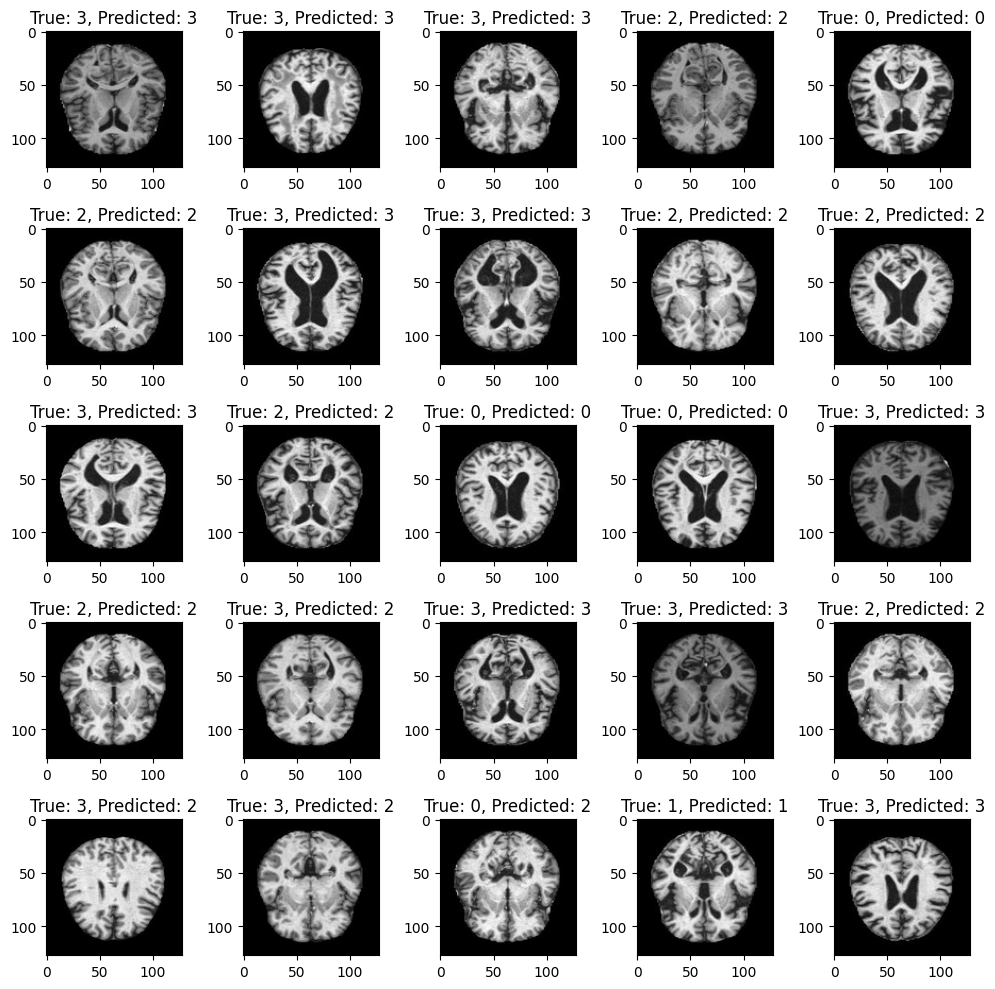

In [ ]:
#visualize some training examples with the model's predicted class v the true label

import matplotlib.pyplot as plt
import numpy as np


model.eval()  # Set the model to evaluation mode

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        if i >= 25:
            break
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        image = inputs[0].cpu().numpy().transpose(1, 2, 0) * 0.4 + 0.1
        image = np.clip(image, 0, 1)
        axes[i//5, i%5].imshow(image)

        axes[i//5, i%5].set_title(f"True: {labels[0].item()}, Predicted: {predicted[0].item()}")

plt.tight_layout()
plt.show()


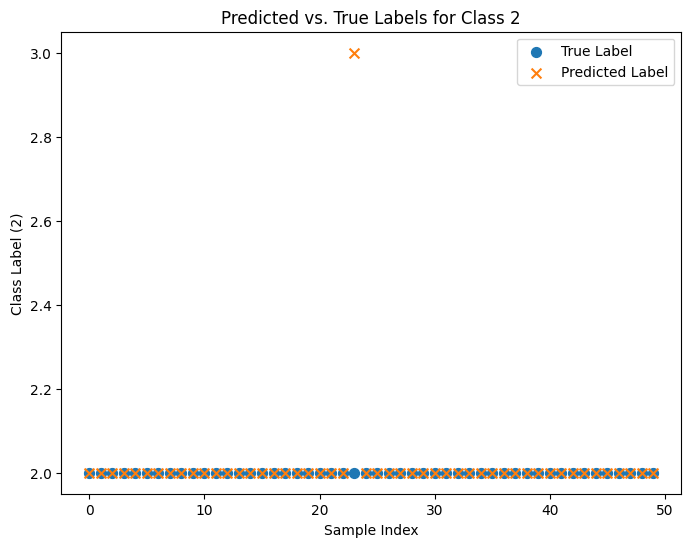

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter predictions and labels for class 1
class_1_indices = np.where(np.array(all_labels) == 2)[0]  # Correctly get indices, can change this depending on which class we want to compare
class_1_preds = np.array(all_preds)[class_1_indices][:50]
class_1_labels = np.array(all_labels)[class_1_indices][:50]


# Create the visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(len(class_1_labels)), class_1_labels, label='True Label', marker='o', s=50)
ax.scatter(range(len(class_1_preds)), class_1_preds, label='Predicted Label', marker='x', s=50)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Class Label (2)")  # corrected label
ax.set_title("Predicted vs. True Labels for Class 2")
ax.legend()
plt.show()
